**Random Forest univariate model for the prediction of meteorological time series data.**

**Autoregressive Random Forest for forecasting**
*Code used and adapted from reference:*  **https://sarem-seitz.com/posts/forecasting-with-decision-trees-and-random-forests/**

# **IMPORT LIBRARIES**

In [ ]:
## IMPORTING REQUIRED LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# **DATA MANIPULATION**

In [ ]:
#--- LOAD DATA ---#
location = 'TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = 'TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

data = pd.read_csv(location, parse_dates=['Fecha']) # PARSE COLUMN "FECHA" TO DATE TYPE
data.head()

,Año,Mes,Dia,Fecha,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
0,2013,Ene,1,2013-01-01,12.038,18.022,7.344,0.956,73.676
1,2013,Ene,2,2013-01-02,12.224,18.000,8.078,3.600,74.553
2,2013,Ene,3,2013-01-03,11.902,17.822,7.667,9.933,76.719
3,2013,Ene,4,2013-01-04,10.906,16.778,7.122,8.800,79.117
4,2013,Ene,5,2013-01-05,11.146,16.267,7.211,4.956,79.746


In [ ]:
# INDEX
# Set the 'Fecha' column as the DataFrame index.
data = data.set_index(['Fecha'])

# CHANGE HEADER NAMES
# Rename columns for clarity
data = data.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad" })

In [ ]:
#--- SELECT TARGET VARIABLE ---#
# DROP COLUMNS THAT ARE NOT GOING TO BE USED
# We are dropping all columns except 'Temp_max' to isolate the target variable.
data = data.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# data = data.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

# Display the first few rows of the dataframe after dropping columns
data.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


In [ ]:
#Check for null values
data.isnull().any()

In [ ]:
# DROP NULL VALUES
data.dropna(inplace=True)

In [ ]:
# DATA SET INFORMATION
data.info()

In [ ]:
# Basic descriptive stats
data.describe()

## **FEATURE ENGINEERING**

In [ ]:
#@title CREATE FEATURES (LAGS)
# This function creates lag features by shifting the target variable values.
def create_lag_features(data, n_lags, target_column):
    for lag in range(1, n_lags + 1):
        # Create a new column for each lag, shifting the target_column values down by 'lag' periods.
        data[f'lag_{lag}'] = data[target_column].shift(lag)
    return data

# **DATA PREPARATION**

In [ ]:
#--- CALL THE CREATE LAGS FUNCTION ---#
n_lags = 15 # SET NUMBER OF LAGS as input features.
target_column = 'Temp_max' # Set the target column name
data = create_lag_features(data, n_lags, target_column)

# Drop rows with NaN values that result from the shifting operation.
data.dropna(inplace=True)

# Extract month and day of the week from the index to capture seasonal patterns.
data['Month'] = data.index.month
data['Day_of_Week'] = data.index.dayofweek

# Separate the data into features (X) and the target variable (y).
X = data.drop(target_column, axis=1) # X contains all columns except the target_column
y = data[target_column] # y contains only the target_column

In [ ]:
X.head(2)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,Month,Day_of_Week
Fecha,,,,,,,,,,,,,,,,,
2013-01-16,17.820,17.71,17.48,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,18.022,1,2
2013-01-17,18.367,17.82,17.71,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,1,3


In [ ]:
y.head(2)

,Temp_max
Fecha,
2013-01-16,18.367
2013-01-17,17.644


## **SPLIT DATA**

In [ ]:
# DATA SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# CHECK DATASET SHAPE
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (3094, 17)
Forma de y_train: (3094,)
Forma de X_test: (774, 17)
Forma de y_test: (774,)


# ***PARAMETERS OPTIMIZATION (OPTIONAL)***

In [ ]:
# IN CASE YOU WANT TO USE SOME PARAMETERS OPTIMIZATION "GridSearchCV"
# param_grid = {
#     'n_estimators': [50, 100, 200, 500, 1000],
#     'max_depth': [5, 10, 20, 50, 100, None],
#     'min_samples_split': [2, 5, 10, 20, 30, 50, 100, 150],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     'bootstrap': [True, False]
# }

# # RANDOM FOREST CONFIGURATION
# rf = RandomForestRegressor(random_state=42)

# # RANDOMIZED SEARCH CV
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
#                                n_iter=100, cv=3, verbose=2, random_state=None, n_jobs=-1)

# # FIT MODEL
# rf_random.fit(X_train, y_train)

# # BEST ESTIMATOR
# best_rf = rf_random.best_estimator_

# print("BEST HYPERPARAMETERS:", rf_random.best_params_)

# **MODEL**

In [ ]:
#@title Model Configuration
# INITIAL RANDOM FOREST MODEL CONFIGURATION
model = RandomForestRegressor(max_depth=5, n_estimators= 1000, min_samples_split= 30, min_samples_leaf= 4, bootstrap= True, oob_score=True) # CHANGE WITH YOUR OWN PARAMETERS

In [ ]:
#@title Model training
# TRAIN THE MODEL
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=30,
                      n_estimators=1000, oob_score=True)

In [ ]:
#@title Model Prediction
# PREDICTIONS
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(y_pred_test)

In [ ]:
#@title Model Evaluation
# EVALUATION
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# EVALUATE TRAIN SET
rmse_train, mae_train, mape_train = evaluate_model(y_train, y_pred_train)

# EVALUATE TEST SET
rmse_test, mae_test, mape_test = evaluate_model(y_test, y_pred_test)

# PRINT METRICS
print(f'TRAIN - RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, MAPE: {mape_train:.5f}%')
print(f'TEST - RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, MAPE: {mape_test:.5f}%')

TRAIN - RMSE: 1.59317, MAE: 1.22169, MAPE: 7.21523%
TEST - RMSE: 1.73251, MAE: 1.31442, MAPE: 7.49148%


# **VISUALIZATION**

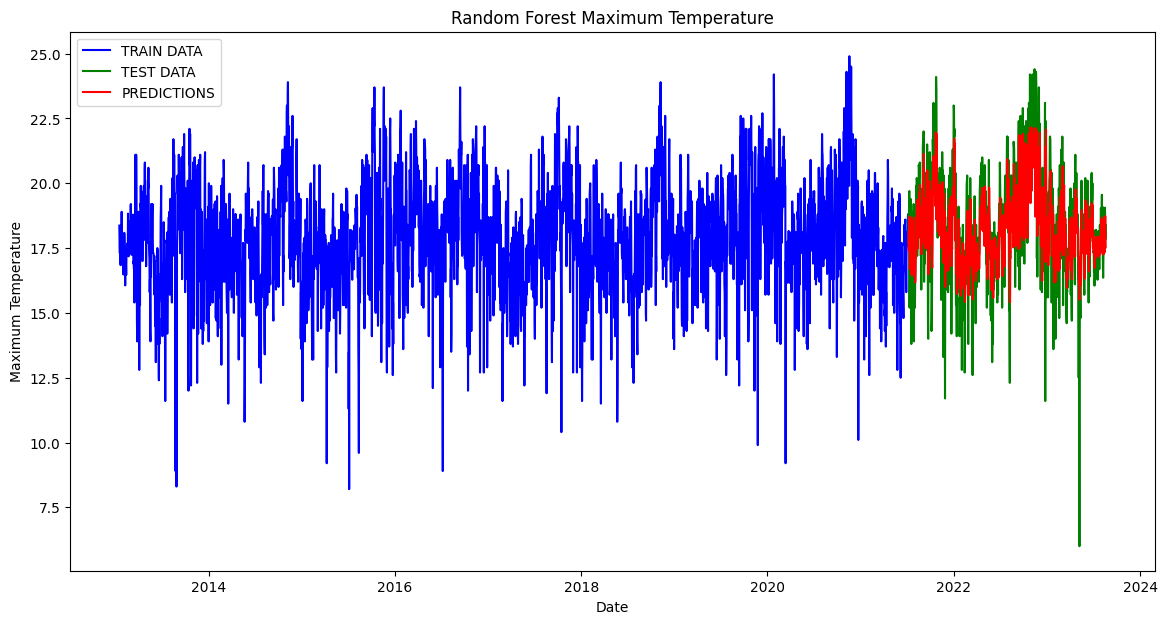

In [ ]:
# TRAIN, TEST AND PREDICTIONS VISUALIZATION
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='TRAIN DATA', color='b')
plt.plot(y_test.index, y_test, label='TEST DATA', color='g')
plt.plot(y_test.index, y_pred_test, label='PREDICTIONS', color='r', linestyle='-')
plt.title('Random Forest Maximum Temperature')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

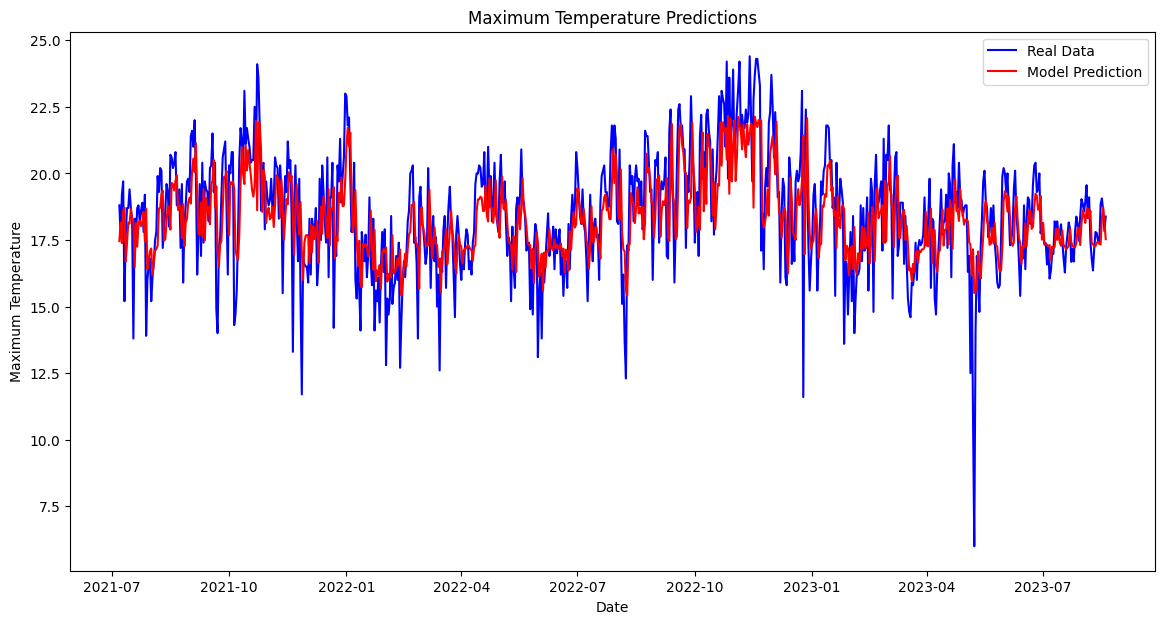

In [ ]:
# Comparision Plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Real Data', color='b')
plt.plot(y_test.index, y_pred_test, label='Model Prediction', color='r')
plt.title('Maximum Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

# **FUTURE PREDICTIONS**

In [ ]:
#@title FUNCTION TO PREDICT
# DRAW FORWARD PREDICTIONS (FOR DATA THAT DOESN'T EXIST)
def predict_future(model, last_observation, n_steps):
    future_predictions = []
    current_observation = last_observation.copy()

    for _ in range(n_steps):
        prediction = model.predict(current_observation.values.reshape(1, -1))[0]
        future_predictions.append(prediction)

        # UPDATE THE ACTUAL OBSERVATION WITH THE NEW PREDICTION
        new_row = np.roll(current_observation.values, -1)
        new_row[-1] = prediction
        current_observation = pd.Series(new_row, index=current_observation.index)

    return future_predictions

In [ ]:
# FORWARD PREDICTIONS
n_future_steps = 365 ## SET FUTURES DAYS OR MONTHS TO PREDICT
last_observation = X_test.iloc[-1]  # LAST TEST SET OBSERVATION
future_predictions = predict_future(model, last_observation, n_future_steps)

# FUTURE PREDICTIONS VISUALIZATION
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_future_steps, freq='D') ## FOR DAILY PREDICTIONS
# future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_future_steps, freq='M') ## FOR MONTHLY PREDICTIONS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

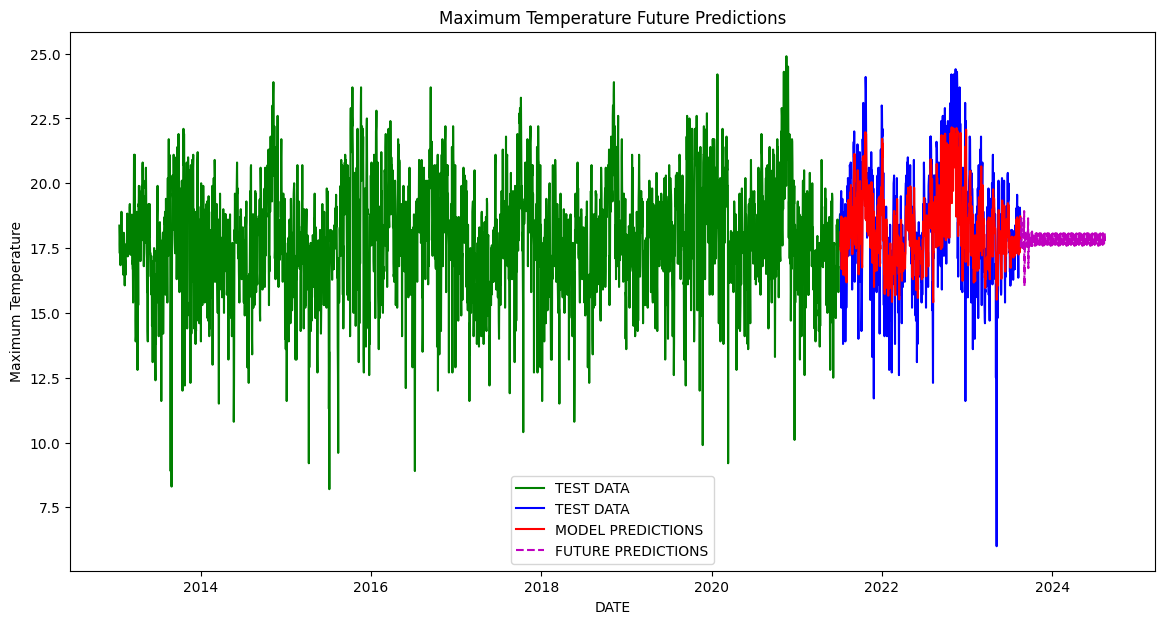

In [ ]:
#@title Plot prediction
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='TEST DATA', color='g')
plt.plot(y_test.index, y_test, label='TEST DATA', color='b')
plt.plot(y_test.index, y_pred_test, label='MODEL PREDICTIONS', color='r')
plt.plot(future_dates, future_predictions, label='FUTURE PREDICTIONS', color='m', linestyle='--')
plt.title('Maximum Temperature Future Predictions')
plt.xlabel('DATE')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

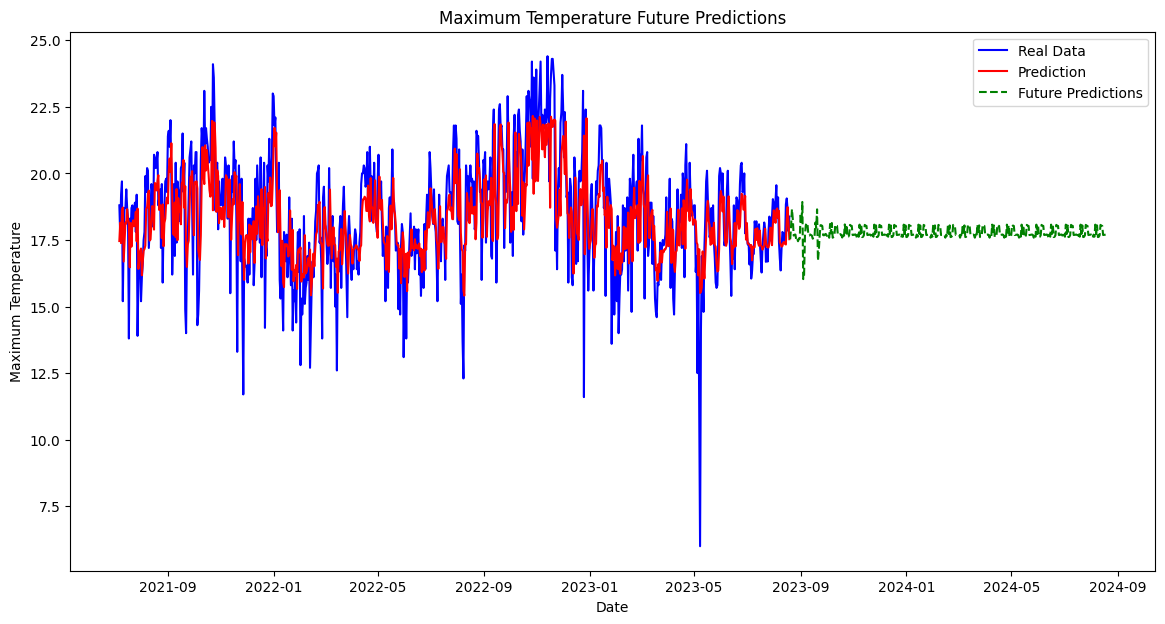

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Real Data', color='b')
plt.plot(y_test.index, y_pred_test, label='Prediction', color='r')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='g', linestyle='--')
plt.title('Maximum Temperature Future Predictions')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

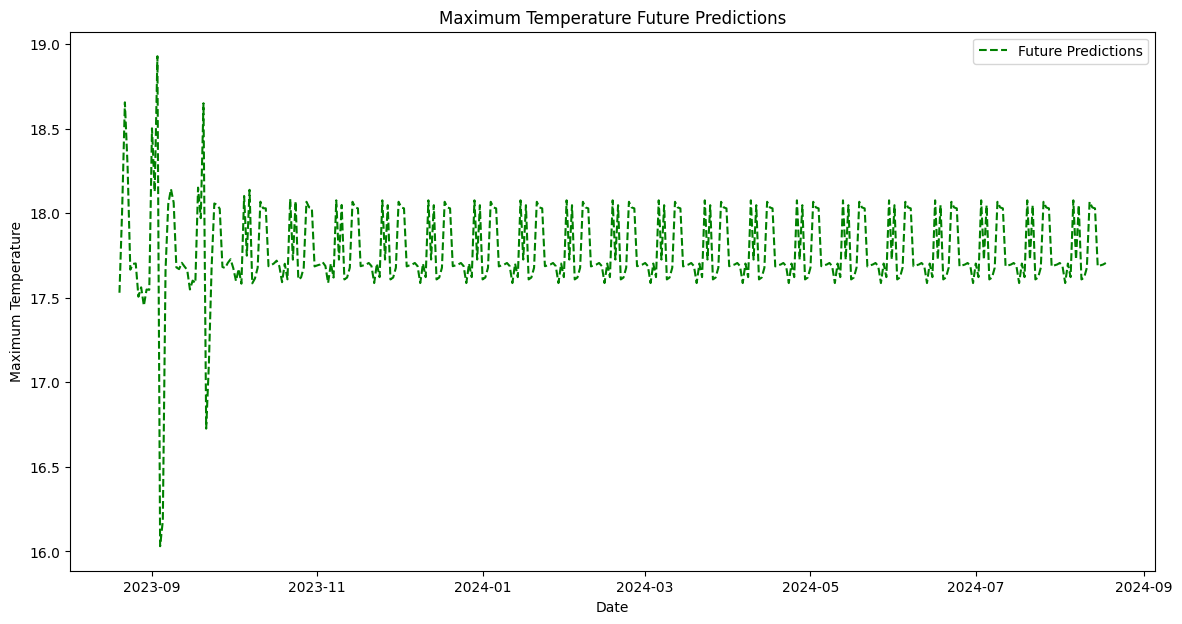

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label='Future Predictions', color='g', linestyle='--')
plt.title('Maximum Temperature Future Predictions')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

# **FEATURE IMPORTANCE**

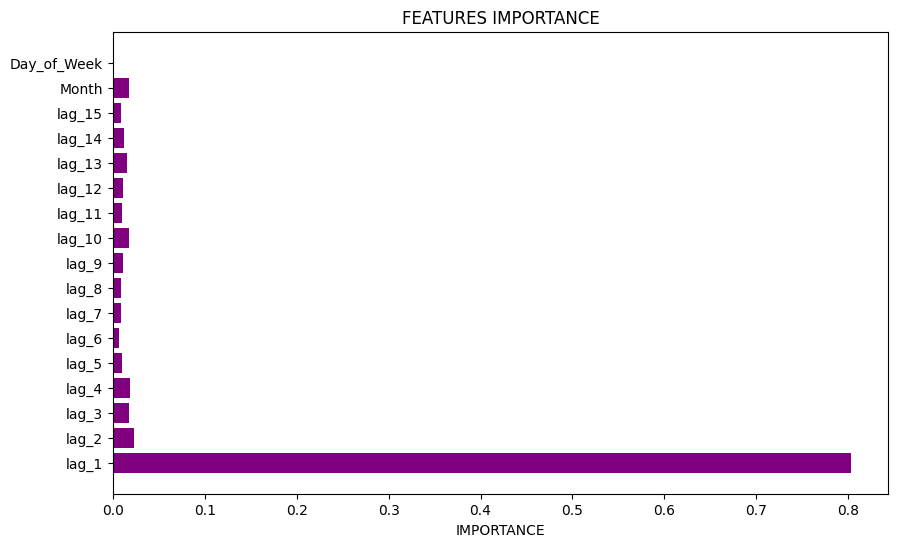

In [ ]:
# FEATURES IMPORTANCE
feature_importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color="purple")
plt.xlabel("IMPORTANCE")
plt.title("FEATURES IMPORTANCE")
plt.show()